<a href="https://colab.research.google.com/github/oveay/AM/blob/main/AM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная номер 2
Выполнили Хауров Никита и Ведерников Ярослав

## Исходная функция и вспомогательные классы
Введём исходную функцию f(x), функцию plot для построения графиков
Также реализуем запоминание значений функции (понадобится для методов Фибонначи, парабол и Брента) и выберем такой её отрезок, чтобы на нём функция была унимодальной

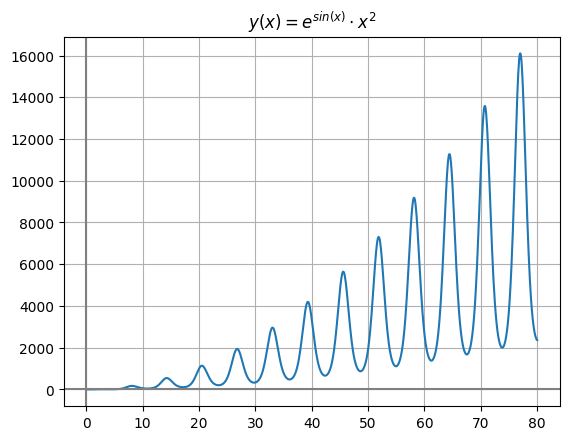

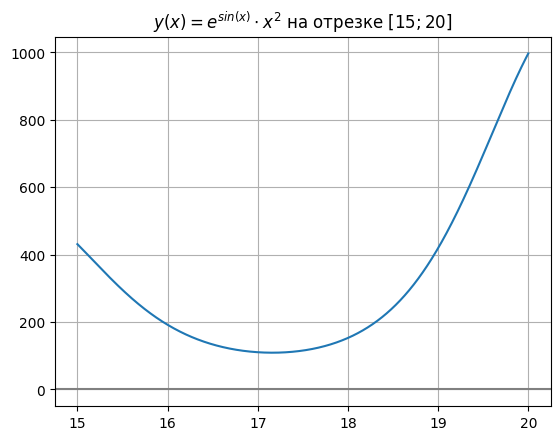

In [ ]:
import numpy as mathematics
import matplotlib.pyplot as graph_plotter
from types import FunctionType

import warnings
warnings.filterwarnings('ignore')


def math_func(x):
    return mathematics.power(mathematics.e, mathematics.sin(x)) * mathematics.power(x, 2)

def draw_graph(f, left_endpoint, right_endpoint, graph_title, show_x_axis=True, show_y_axis=True):
    x = mathematics.linspace(left_endpoint, right_endpoint, 1000)
    y = f(x)
    graph_plotter.plot(x, y)
    graph_plotter.grid()
    if show_x_axis:
        graph_plotter.axhline(y=0, color="grey")
    if show_y_axis:
        graph_plotter.axvline(x=0, color="grey")
    graph_plotter.title(graph_title)
    graph_plotter.show()


# Кэширование функции
class CachedFunction:
    def __init__(self, math_func):
        self.math_func = math_func
        self.call_cache = {}

    def __call__(self, x):
        if x not in self.call_cache:
            self.call_cache[x] = self.math_func(x)
        return self.call_cache[x]

    def get_call_count(self):
        return len(self.call_cache)


draw_graph(math_func, 0.0001, 80, "$y(x) = e^{sin(x)} \cdot x^2$")

# Границы отрезка на котором функция унимодальна
l = 15
r = 20

draw_graph(math_func, l, r, "$y(x) = e^{sin(x)} \cdot x^2$ на отрезке $[15; 20]$", show_y_axis=False)

## Алгоритмы минимизации

In [ ]:
from types import FunctionType

phi = (1 + mathematics.sqrt(5)) / 2

# Метод дихотомии
def dichotomy_search(func: FunctionType, left_endpoint, right_endpoint, epsilon=1e-6, delta_func=lambda x, y: (y - x) / 8):
    iterations = 0
    segment_lengths = [right_endpoint - left_endpoint]
    while right_endpoint - left_endpoint > epsilon:
        middle_point = (left_endpoint + right_endpoint) / 2
        delta = delta_func(left_endpoint, right_endpoint)
        x_1 = middle_point - delta
        x_2 = middle_point + delta
        if func(x_1) < func(x_2):
            right_endpoint = x_2
        else:
            left_endpoint = x_1
        iterations += 1
        segment_lengths.append(right_endpoint - left_endpoint)
    return {
        "value": (left_endpoint + right_endpoint) / 2,
        "iterations": iterations,
        "calls": iterations * 2,
        "segment_lengths": segment_lengths,
    }

# Метод золотого сечения
def golden_section(func: CachedFunction, left_endpoint, right_endpoint, epsilon=1e-6):
    iterations = 0
    segment_lengths = [right_endpoint - left_endpoint]
    while right_endpoint - left_endpoint > epsilon:
        delta = (right_endpoint - left_endpoint) / phi
        x_1 = right_endpoint - delta
        x_2 = left_endpoint + delta
        if func(x_1) < func(x_2):
            right_endpoint = x_2
        else:
            left_endpoint = x_1
        iterations += 1
        segment_lengths.append(right_endpoint - left_endpoint)
    return {
        "value": (left_endpoint + right_endpoint) / 2,
        "iterations": iterations,
        "calls": func.get_call_count(),
        "segment_lengths": segment_lengths,
    }

# Метод Фибоначчи
def fibonacci(func: CachedFunction, left_endpoint, right_endpoint, epsilon=1e-6):
    max_iterations = int((right_endpoint - left_endpoint) / epsilon)
    fib = [1, 1]
    while fib[-1] < max_iterations:
        fib.append(fib[-1] + fib[-2])

    n = len(fib) - 1
    if n <= 2:
        return (left_endpoint + right_endpoint) / 2

    iterations = 0
    segment_length = [right_endpoint - left_endpoint]
    while n > 2:
        x_1 = left_endpoint + fib[-3] / fib[-1] * (right_endpoint - left_endpoint)
        x_2 = left_endpoint + fib[-2] / fib[-1] * (right_endpoint - left_endpoint)

        if func(x_1) < func(x_2):
            right_endpoint = x_2
        else:
            left_endpoint = x_1
        fib.pop()
        n -= 1
        iterations += 1
        segment_length.append(right_endpoint - left_endpoint)
    return {
        "value": (left_endpoint + right_endpoint) / 2,
        "iterations": iterations,
        "calls": func.get_call_count(),
        "segment_lengths": segment_length,
    }

# Минимум параболы
def minimum(f, x_1, x_2, x_3):
    return x_2 - ((x_2 - x_1) ** 2 * (f(x_2) - f(x_3)) - (x_2 - x_3) ** 2 * (f(x_2) - f(x_1))) / (2 * (x_2 - x_1) * (f(x_2) - f(x_3)) - (x_2 - x_3) * (f(x_2) - f(x_1)))

# Метод парабол
def parabolic(func: CachedFunction, left_endpoint, right_endpoint, epsilon=1e-6):
    x_2 = (left_endpoint + right_endpoint) / 2

    iterations = 0
    segment_length = [right_endpoint - left_endpoint]
    while right_endpoint - left_endpoint > epsilon:
        u = minimum(func, left_endpoint, x_2, right_endpoint)
        if func(x_2) < func(u):
            if x_2 < u:
                right_endpoint = u
            else:
                left_endpoint = u

        else:
            if x_2 < u:
                left_endpoint = x_2
            else:
                right_endpoint = x_2
            x_2 = u
        iterations += 1
        segment_length.append(right_endpoint - left_endpoint)
    return {
        "value": (left_endpoint + right_endpoint) / 2,
        "iterations": iterations,
        "calls": func.get_call_count(),
        "segment_lengths": segment_length,
    }

# Метод Брэнта
def brent(func: CachedFunction, left_endpoint, right_endpoint, epsilon=1e-6):
    x = (left_endpoint + right_endpoint) / 2
    w = x  # предыдущее значение x или u
    v = x  # предпредыдущее значение x или u
    e = d = right_endpoint - left_endpoint  # удаление u от x

    iterations = 0
    segment_length = [right_endpoint - left_endpoint]
    while (right_endpoint - left_endpoint) > epsilon:
        g = e
        e = d
        accept = False
        if x != w and w != v and x != v and func(x) != func(w) and func(x) != func(v) and func(w) != func(v):
            u = minimum(func, x, w, v)
            if left_endpoint + epsilon <= u <= right_endpoint - epsilon and abs(u - x) < g / 2:
                accept = True
                d = abs(u - x)

        if not accept:
            if x < (left_endpoint + right_endpoint) / 2:
                delta = (right_endpoint - x) / phi
                u = right_endpoint - delta  # золотое сечение [x, c]
                d = right_endpoint - x
            else:
                delta = (x - left_endpoint) / phi
                u = left_endpoint + delta  # золотое сечение [a, x]
                d = x - left_endpoint

        if func(u) <= func(x):
            if u >= x:
                left_endpoint = x
            else:
                right_endpoint = x
            v = w
            w = x
            x = u
        else:
            if u >= x:
                right_endpoint = u
            else:
                left_endpoint = u
            if func(u) <= func(w):
                v = w
                w = u
            elif func(u) <= func(v) or v == x or v == w:
                v = u
        iterations += 1
        segment_length.append(right_endpoint - left_endpoint)
    return {
        "value": (left_endpoint + right_endpoint) / 2,
        "iterations": iterations,
        "calls": func.get_call_count(),
        "segment_lengths": segment_length,
    }

## Решение

In [ ]:
print("Метод дихотомии:", dichotomy_search(math_func, l, r, 0.01)["value"])
print("Метод золотого сечения:", golden_section(CachedFunction(math_func), l, r, 0.01)["value"])
print("Метод Фибоначчи:", fibonacci(CachedFunction(math_func), l, r, 0.01)["value"])
print("Метод парабол:", parabolic(CachedFunction(math_func), l, r, 0.01)["value"])
print("Метод Брента:", brent(CachedFunction(math_func), l, r, 0.01)["value"])

Метод дихотомии: 17.162110505000214
Метод золотого сечения: 17.162212752917064
Метод Фибоначчи: 17.16393442622951
Метод парабол: 17.161957360415457
Метод Брента: 17.163693034931395


## Зависимость кол-ва итераций от точности

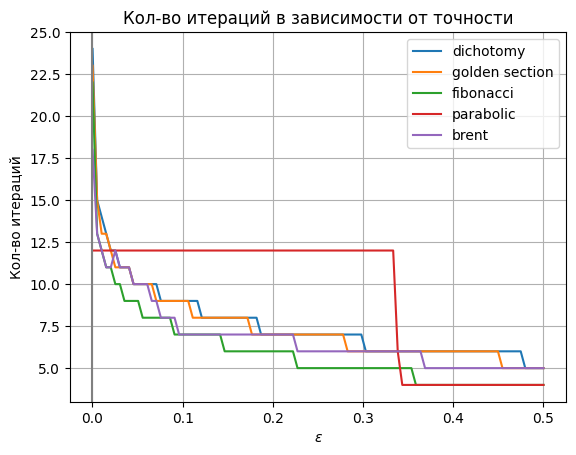

In [ ]:
epsilons = mathematics.linspace(0.0001, 0.5, 100)

results = {
    "dichotomy": [dichotomy_search(math_func, l, r, epsilon) for epsilon in epsilons],
    "golden section": [golden_section(CachedFunction(math_func), l, r, epsilon) for epsilon in epsilons],
    "fibonacci": [fibonacci(CachedFunction(math_func), l, r, epsilon) for epsilon in epsilons],
    "parabolic": [parabolic(CachedFunction(math_func), l, r, epsilon) for epsilon in epsilons],
    "brent": [brent(CachedFunction(math_func), l, r, epsilon) for epsilon in epsilons],
}

for method in results:
    graph_plotter.plot(epsilons, [result["iterations"] for result in results[method]], label=method)
graph_plotter.legend()
graph_plotter.grid()
graph_plotter.axvline(x=0, color="grey")
graph_plotter.title("Кол-во итераций в зависимости от точности")
graph_plotter.xlabel(r"$\varepsilon$")
graph_plotter.ylabel("Кол-во итераций")
graph_plotter.show()

## Кол-во вычислений функции в зависимости от точности

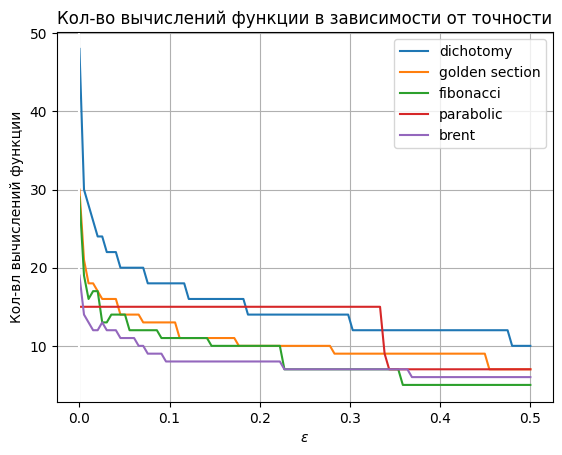

In [ ]:
for method in results:
    graph_plotter.plot(epsilons, [result["calls"] for result in results[method]], label=method)
graph_plotter.legend()
graph_plotter.grid()
graph_plotter.axvline(x=0, color="white")
graph_plotter.title("Кол-во вычислений функции в зависимости от точности")
graph_plotter.xlabel(r"$\varepsilon$")
graph_plotter.ylabel("Кол-вл вычислений функции")
graph_plotter.show()

## Зависимость размера отрезка от номера итерации

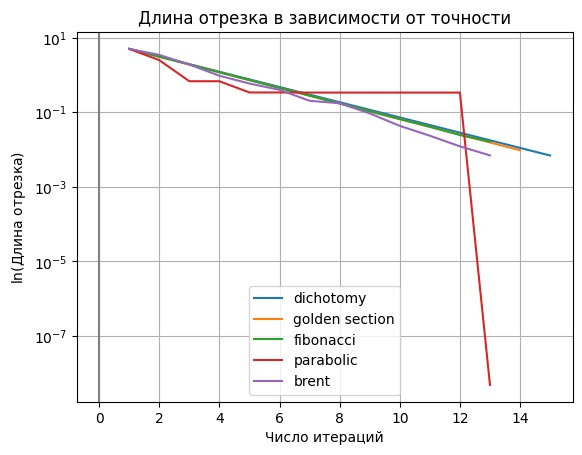

In [ ]:
results = {
    "dichotomy": dichotomy_search(math_func, l, r, 0.01),
    "golden section": golden_section(CachedFunction(math_func), l, r, 0.01),
    "fibonacci": fibonacci(CachedFunction(math_func), l, r, 0.01),
    "parabolic": parabolic(CachedFunction(math_func), l, r, 0.01),
    "brent": brent(CachedFunction(math_func), l, r, 0.01),
}

for method in results:
    graph_plotter.plot(list(range(1, len(results[method]["segment_lengths"]) + 1)), results[method]["segment_lengths"], label=method)
graph_plotter.yscale("log")
graph_plotter.legend()
graph_plotter.grid()
graph_plotter.axvline(x=0, color="grey")
graph_plotter.title("Длина отрезка в зависимости от точности")
graph_plotter.xlabel("Число итераций")
graph_plotter.ylabel(r"$\ln($Длина отрезка$)$")
graph_plotter.show()

## Минимизация для многомодальных функций

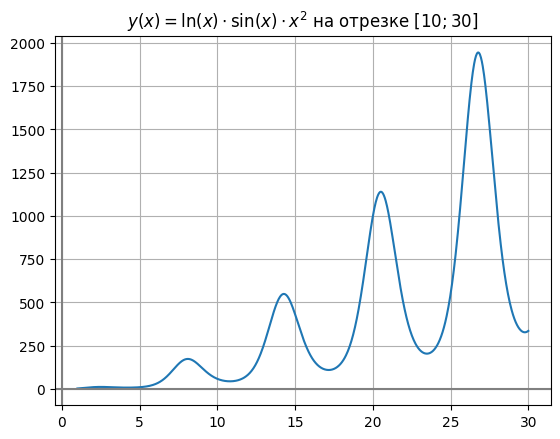

Метод дихотомии: 4.218491243241537
Метод золотого сечения: 4.218381590210766
Метод Фибоначчи: 4.218271277523817
Метод парабол: -6.088900818034721e-162
Метод Брента: 10.809510066426164


In [ ]:
draw_graph(math_func, 1, 30, "$y(x) = \ln(x) \cdot \sin(x) \cdot x^2$ на отрезке $[10; 30]$")

print("Метод дихотомии:", dichotomy_search(math_func, 1, 20, 0.001)["value"])
print("Метод золотого сечения:", golden_section(CachedFunction(math_func), 1, 20, 0.001)["value"])
print("Метод Фибоначчи:", fibonacci(CachedFunction(math_func), 1, 20, 0.001)["value"])
print("Метод парабол:", parabolic(CachedFunction(math_func), 1, 20, 0.001)["value"])
print("Метод Брента:", brent(CachedFunction(math_func), 1, 20, 0.001)["value"])

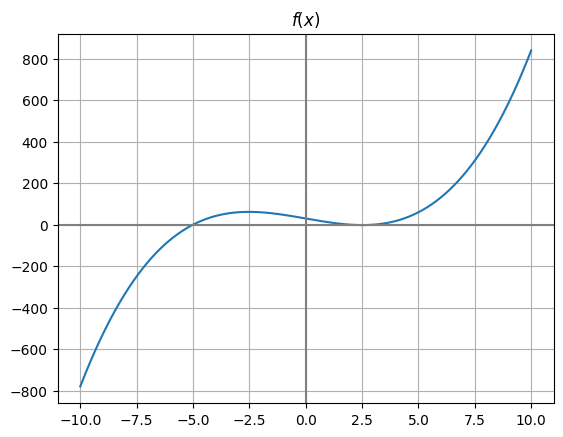

Метод дихотомии: 2.516567400868401
Метод золотого сечения: 2.516699874051833
Метод Фибоначчи: 2.516901151105426
Метод парабол: 2.5166114803126707
Метод Брента: 2.516820002130706


In [ ]:
def f1(x):
    return x ** 3 - 19 * x + 30

draw_graph(f1, -10, 10, "$f(x)$")

print("Метод дихотомии:", dichotomy_search(f1, 0, 10, 0.001)["value"])
print("Метод золотого сечения:", golden_section(CachedFunction(f1), 0, 10, 0.001)["value"])
print("Метод Фибоначчи:", fibonacci(CachedFunction(f1), 0, 10, 0.001)["value"])
print("Метод парабол:", parabolic(CachedFunction(f1), 0, 10, 0.001)["value"])
print("Метод Брента:", brent(CachedFunction(f1), 0, 10, 0.001)["value"])